In [1]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def categorize_fordri():
    west_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_westernUS.csv",index_col=0).iloc[:,2:]
    east_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_easternUS.csv",index_col=0).iloc[:,2:]
    west_fordri[west_fordri>=0] = 1
    west_fordri[(west_fordri>=-1)&(west_fordri<0)] = 2
    west_fordri[(west_fordri>=-2)&(west_fordri<-1)] = 3
    west_fordri[west_fordri<-2] = 4
    east_fordri[east_fordri>=0] = 1
    east_fordri[(east_fordri>=-1)&(east_fordri<0)] = 2
    east_fordri[(east_fordri>=-2)&(east_fordri<-1)] = 3
    east_fordri[east_fordri<-2] = 4
    
    return west_fordri, east_fordri

## Validate ForDRI based on the Tree Ring Standardized Growth Index (TRSGI)

### Using the **complete** yearly FoDRI data

In [24]:
west_fordri, east_fordri = categorize_fordri()

In [25]:
# removing month in order to group the data into years
west_fordri.columns = west_fordri.columns.str[:4]
west_fordri = west_fordri.T

east_fordri.columns = east_fordri.columns.str[:4]
east_fordri = east_fordri.T

In [ ]:
# calculate the frequecy of the categorical ForDRI in a year (west)
agg_west_fordri = pd.DataFrame(columns=west_fordri.columns)
list_ForDRI = []
for y in range(2003, 2024):
    df = west_fordri.loc[west_fordri.index==str(y),:]
    df_count = df.apply(pd.value_counts)
    df_count = df_count.replace(np.nan,0)/52
    if len(df_count.index) == 3:
        df_count.loc[4.0] = [0]*57
    elif len(df_count.index) == 2:
        df_count.loc[3.0] = [0]*57
        df_count.loc[4.0] = [0]*57
    agg_west_fordri = pd.concat([agg_west_fordri,df_count])

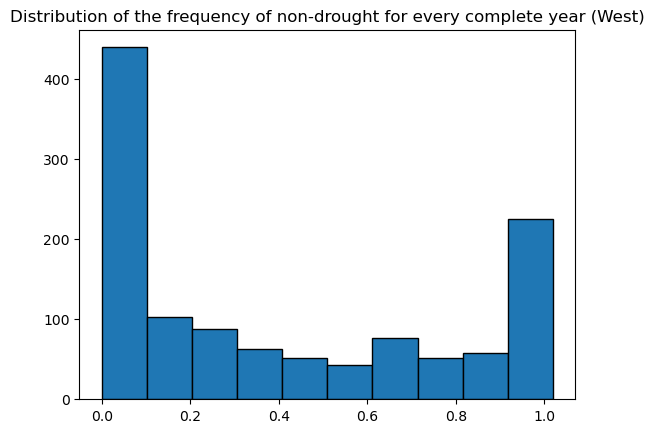

In [16]:
plt.figure()
plt.hist(agg_west_fordri.loc[agg_west_fordri.index==1.0,:].values.flatten(),edgecolor = 'black',bins=10)
plt.title("Distribution of the frequency of non-drought for every complete year (West)")
plt.show()

In [ ]:
# calculate the frequecy of the categorical ForDRI in a year (east)
agg_east_fordri = pd.DataFrame(columns=east_fordri.columns)
list_ForDRI = []
for y in range(2003, 2024):
    df = east_fordri.loc[east_fordri.index==str(y),:]
    df_count = df.apply(pd.value_counts)
    df_count = df_count.replace(np.nan,0)/52
    if len(df_count.index) == 3:
        df_count.loc[4.0] = [0]*9
    elif len(df_count.index) == 2:
        df_count.loc[3.0] = [0]*9
        df_count.loc[4.0] = [0]*9
    agg_east_fordri = pd.concat([agg_east_fordri,df_count])

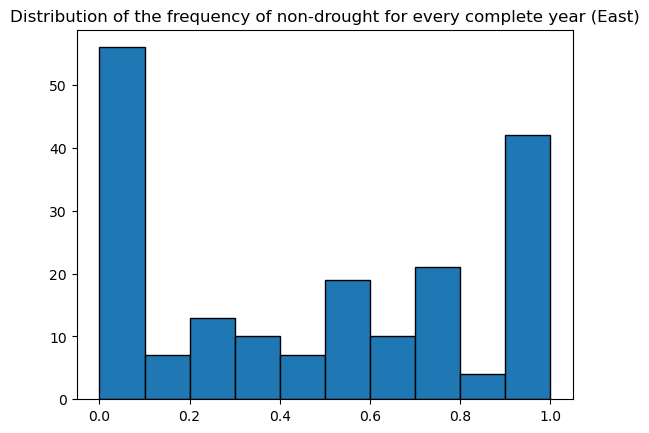

In [28]:
plt.figure()
plt.hist(agg_east_fordri.loc[agg_east_fordri.index==1.0,:].values.flatten(),edgecolor = 'black',bins=10)
plt.title("Distribution of the frequency of non-drought for every complete year (East)")
plt.show()

In [31]:
# Calculating the aggregated ForDRI (West)
west_annual = pd.DataFrame(columns = np.arange(2003,2024,1))
for i in range(0,57):
    col_name = agg_west_fordri.columns.values[i]
    col_val = agg_west_fordri.iloc[:,i]
    new_val = col_val * agg_west_fordri.index.values.astype("int")
    sum_val = np.array([])
    for j in range(21):
        j_sum = np.sum(new_val.values[j*4:(j+1)*4])
        sum_val = np.append(sum_val, j_sum)
    west_annual.loc[col_name] = sum_val

In [33]:
west_annual.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/integrated_annual_fordri_west.csv")

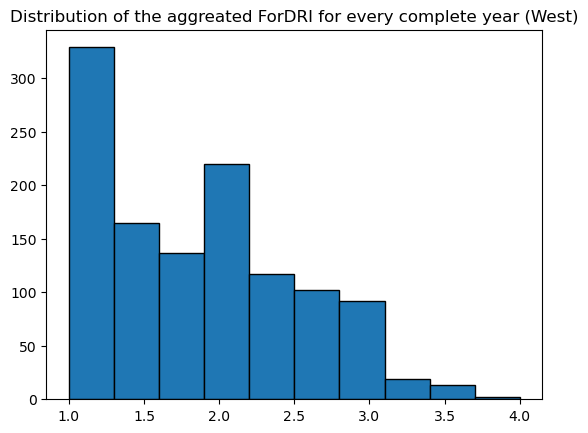

In [34]:
# plot the distribution aggregated ForDRI (West)
plt.figure()
plt.hist(west_annual.values.flatten(),edgecolor = 'black',bins=10,range=(1,4))
plt.title("Distribution of the aggreated ForDRI for every complete year (West)")
plt.show()

In [35]:
# Calculating the aggregated ForDRI (East)
east_annual = pd.DataFrame(columns = np.arange(2003,2024,1))
for i in range(0,9):
    col_name = agg_east_fordri.columns.values[i]
    col_val = agg_east_fordri.iloc[:,i]
    new_val = col_val * agg_east_fordri.index.values.astype("int")
    sum_val = np.array([])
    for j in range(21):
        j_sum = np.sum(new_val.values[j*4:(j+1)*4])
        sum_val = np.append(sum_val, j_sum)
    east_annual.loc[col_name] = sum_val

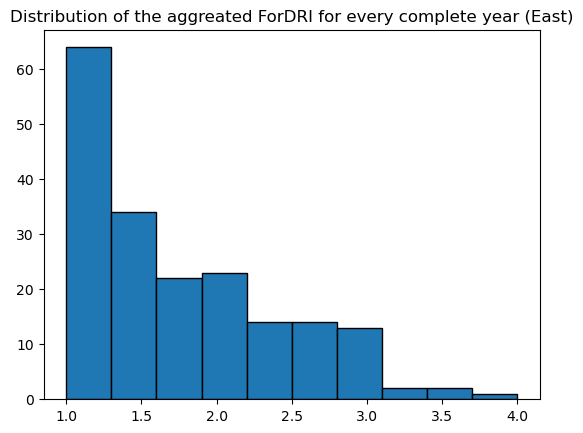

In [36]:
# plot the distribution aggregated ForDRI (East)
plt.figure()
plt.hist(east_annual.values.flatten(),edgecolor = 'black',bins=10,range=(1,4))
plt.title("Distribution of the aggreated ForDRI for every complete year (East)")
plt.show()

In [37]:
east_annual.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/integrated_annual_fordri_east.csv")

In [ ]:
# Calculate the Spearman Correlation and plot the map (easternUS)
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_easternUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(columns = ["Pearson-r", "Pearson-r p-value", "Spearman-r", "Spearman-r p-value"])
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    end_year = df.iloc[:,0].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = east_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    pearson_r = pearsonr(-trsgi,fordri)
    spearman_r = spearmanr(-trsgi,fordri)
    print(stdtr_name)
    print("Pearson R: ", pearson_r)
    print("Spearman R: ", spearman_r)
    out_corr_df.loc[stdtr_name] = [pearson_r[0],pearson_r[1],spearman_r[0],spearman_r[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "blue", marker = 'o',label = "Integrated Annual ForDRI")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Integrated Annual ForDRI")
    #ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    fig.legend(ncol=2, loc='lower right')
    ax1.set_title(stdtr_name)
    #plt.show()
    plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_allseasons_easternUS/"+stdtr_name+'.png', dpi = 300)
    # export the csv file of the correlation
    out_corr_df.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_allseasons_easternUS/correlation_ForDRI_TRSGI.csv")

In [40]:
# Calculate the Spearman Correlation and plot the map (western)
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_westernUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(columns=["Pearson-r", "Pearson-r p-value", "Spearman-r", "Spearman-r p-value"])
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr,index_col=1).iloc[:,1:] # revised based on the western US file format
    end_year = df.index.values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    pearson_r = pearsonr(-trsgi,fordri)
    spearman_r = spearmanr(-trsgi,fordri)
    print(stdtr_name)
    print("Pearson R: ", pearson_r)
    print("Spearman R: ", spearman_r)
    out_corr_df.loc[stdtr_name] = [pearson_r[0],pearson_r[1],spearman_r[0],spearman_r[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "blue", marker = 'o',label = "Integrated Annual ForDRI")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    fig.legend(ncol=2, loc='lower right')
    ax1.set_title(stdtr_name)
    #plt.show()
    plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_allseasons_westernUS/"+stdtr_name+'.png', dpi = 300)
    plt.close()
    # export the csv file of the correlation
    out_corr_df.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_allseasons_westernUS/correlation_ForDRI_TRSGI.csv")

AZ566
Pearson R:  PearsonRResult(statistic=0.6590314406334778, pvalue=0.10738056180362)
Spearman R:  SignificanceResult(statistic=0.5357142857142858, pvalue=0.21521745567801273)


AZ567
Pearson R:  PearsonRResult(statistic=0.683499003056472, pvalue=0.0904658161458126)
Spearman R:  SignificanceResult(statistic=0.4642857142857144, pvalue=0.2939341076002517)
AZ580
Pearson R:  PearsonRResult(statistic=0.8865513894740205, pvalue=0.0033468254371001186)
Spearman R:  SignificanceResult(statistic=0.9285714285714287, pvalue=0.0008629681828999769)
AZ583
Pearson R:  PearsonRResult(statistic=0.8499484244890834, pvalue=0.007524206984371915)
Spearman R:  SignificanceResult(statistic=0.8192771084337348, pvalue=0.012828551944443633)
AZ585
Pearson R:  PearsonRResult(statistic=0.8661263068695892, pvalue=0.00541213402570534)
Spearman R:  SignificanceResult(statistic=0.8622909085775464, pvalue=0.005872990672297006)
AZ587
Pearson R:  PearsonRResult(statistic=-0.015916423527902606, pvalue=0.9729828626681275)
Spearman R:  SignificanceResult(statistic=0.054056247761733546, pvalue=0.9083652825239955)
AZ588
Pearson R:  PearsonRResult(statistic=0.8094330835254765, pvalue=0.0273988168548850

### Using the **growing season** FoDRI data 

In [44]:
west_fordri, east_fordri = categorize_fordri()

In [45]:
# Extracting ForDRI values during the growing season
west_fordri = west_fordri.loc[:, west_fordri.columns.str[-2:].isin(np.arange(18,43,1).astype("str"))]
east_fordri = east_fordri.loc[:, east_fordri.columns.str[-2:].isin(np.arange(18,43,1).astype("str"))]

In [46]:
# removing month in order to group the data into years
west_fordri.columns = west_fordri.columns.str[:4]
west_fordri = west_fordri.T

east_fordri.columns = east_fordri.columns.str[:4]
east_fordri = east_fordri.T

In [ ]:
# calculate the frequecy of the categorical ForDRI in the growing season of a year (west)
agg_west_fordri = pd.DataFrame(columns = west_fordri.columns)
list_ForDRI = []
for y in range(2003, 2024):
    df = west_fordri.loc[west_fordri.index==str(y),:]
    df_count = df.apply(pd.value_counts)
    df_count = df_count.replace(np.nan,0)/25
    if len(df_count.index) == 3:
        df_count.loc[4.0] = [0]*57
    elif len(df_count.index) == 2:
        df_count.loc[3.0] = [0]*57
        df_count.loc[4.0] = [0]*57
    agg_west_fordri = pd.concat([agg_west_fordri,df_count])

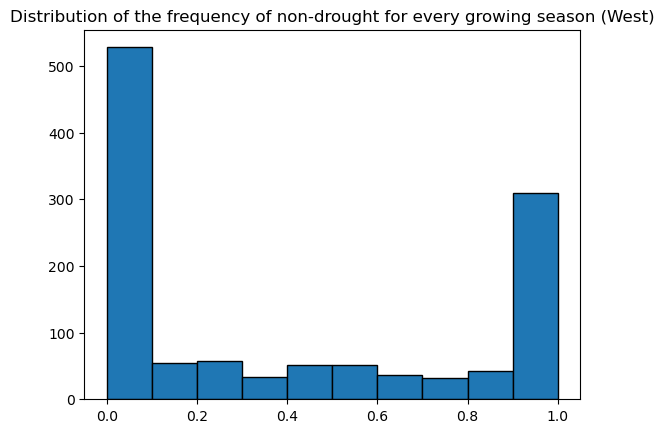

In [49]:
plt.figure()
plt.hist(agg_west_fordri.loc[agg_west_fordri.index==1.0,:].values.flatten(),edgecolor = 'black',bins=10)
plt.title("Distribution of the frequency of non-drought for every growing season (West)")
plt.show()

In [ ]:
# calculate the frequecy of the categorical ForDRI in the growing season of a year (east)
agg_east_fordri = pd.DataFrame(columns=east_fordri.columns)
list_ForDRI = []
for y in range(2003, 2024):
    df = east_fordri.loc[east_fordri.index==str(y),:]
    df_count = df.apply(pd.value_counts)
    df_count = df_count.replace(np.nan,0)/25
    if len(df_count.index) == 3:
        df_count.loc[4.0] = [0]*9
    elif len(df_count.index) == 2:
        df_count.loc[3.0] = [0]*9
        df_count.loc[4.0] = [0]*9
    agg_east_fordri = pd.concat([agg_east_fordri,df_count])

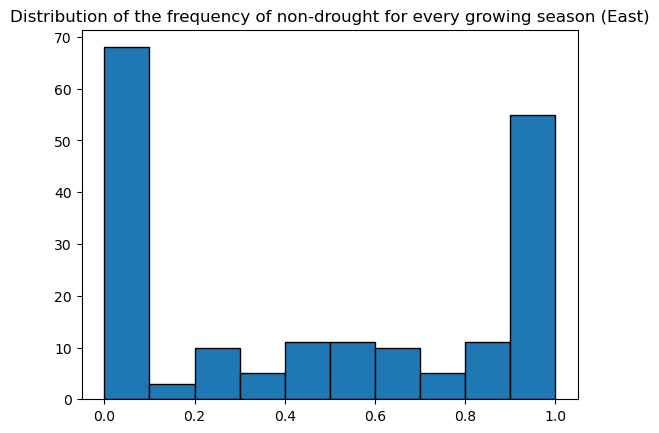

In [51]:
plt.figure()
plt.hist(agg_east_fordri.loc[agg_east_fordri.index==1.0,:].values.flatten(),edgecolor = 'black',bins=10)
plt.title("Distribution of the frequency of non-drought for every growing season (East)")
plt.show()

In [53]:
# Calculating the aggregated ForDRI in growing season (West)
west_annual = pd.DataFrame(columns = np.arange(2003,2024,1))
for i in range(0,57):
    col_name = agg_west_fordri.columns.values[i]
    col_val = agg_west_fordri.iloc[:,i]
    new_val = col_val * agg_west_fordri.index.values.astype("int")
    sum_val = np.array([])
    for j in range(21):
        j_sum = np.sum(new_val.values[j*4:(j+1)*4])
        sum_val = np.append(sum_val, j_sum)
    west_annual.loc[col_name] = sum_val

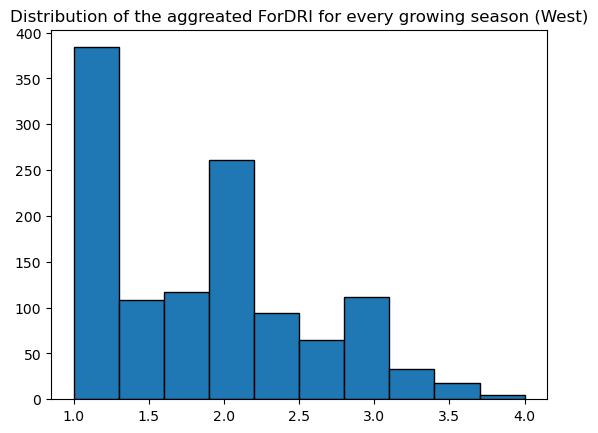

In [54]:
# plot the distribution aggregated ForDRI (West)
plt.figure()
plt.hist(west_annual.values.flatten(),edgecolor = 'black',bins=10,range=(1,4))
plt.title("Distribution of the aggreated ForDRI for every growing season (West)")
plt.show()

In [55]:
west_annual.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/integrated_growing_season_fordri_west.csv")

In [56]:
# Calculating the aggregated ForDRI (East)
east_annual = pd.DataFrame(columns = np.arange(2003,2024,1))
for i in range(0,9):
    col_name = agg_east_fordri.columns.values[i]
    col_val = agg_east_fordri.iloc[:,i]
    new_val = col_val * agg_east_fordri.index.values.astype("int")
    sum_val = np.array([])
    for j in range(21):
        j_sum = np.sum(new_val.values[j*4:(j+1)*4])
        sum_val = np.append(sum_val, j_sum)
    east_annual.loc[col_name] = sum_val

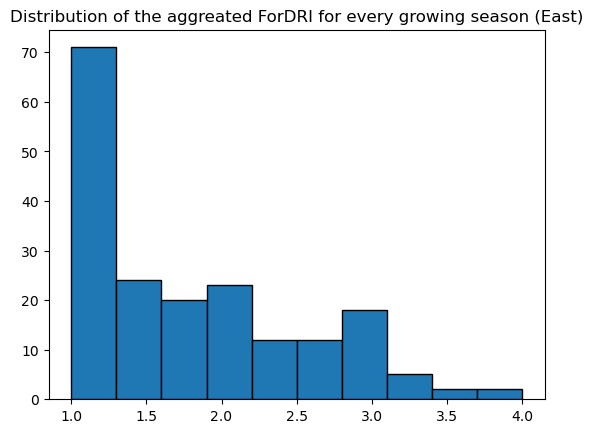

In [57]:
# plot the distribution aggregated ForDRI (East)
plt.figure()
plt.hist(east_annual.values.flatten(),edgecolor = 'black',bins=10,range=(1,4))
plt.title("Distribution of the aggreated ForDRI for every growing season (East)")
plt.show()

In [58]:
east_annual.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/integrated_growing_season_fordri_east.csv")

In [ ]:
# Calculate the Spearman Correlation in the growing season and plot the map (easternUS)
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_easternUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(columns = ["Pearson-r", "Pearson-r p-value", "Spearman-r", "Spearman-r p-value"])
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    end_year = df.iloc[:,0].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = east_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    pearson_r = pearsonr(-trsgi,fordri)
    spearman_r = spearmanr(-trsgi,fordri)
    print(stdtr_name)
    print("Pearson R: ", pearson_r)
    print("Spearman R: ", spearman_r)
    out_corr_df.loc[stdtr_name] = [pearson_r[0],pearson_r[1],spearman_r[0],spearman_r[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "blue", marker = 'o',label = "Integrated Annual ForDRI")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Integrated Annual ForDRI")
    #ax1.set_ylim(0,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    fig.legend(ncol=2, loc='lower right')
    ax1.set_title(stdtr_name)
    # plt.show()
    plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_growingseasons_easternUS/"+stdtr_name+'.png', dpi = 300)
    # export the csv file of the correlation
    out_corr_df.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_growingseasons_easternUS/correlation_ForDRI_TRSGI.csv")

In [ ]:
# Calculate the Spearman Correlation in the growing season and plot the map (west)
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_westernUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(columns = ["Pearson-r", "Pearson-r p-value", "Spearman-r", "Spearman-r p-value"])
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr,index_col=1).iloc[:,1:] # revised based on the western US file format
    end_year = df.index.values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    pearson_r = pearsonr(-trsgi,fordri)
    spearman_r = spearmanr(-trsgi,fordri)
    print(stdtr_name)
    print("Pearson R: ", pearson_r)
    print("Spearman R: ", spearman_r)
    out_corr_df.loc[stdtr_name] = [pearson_r[0],pearson_r[1],spearman_r[0],spearman_r[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "blue", marker = 'o',label = "Integrated Annual ForDRI")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    fig.legend(ncol=2, loc='lower right')
    ax1.set_title(stdtr_name)
    #plt.show()
    plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_growingseasons_westernUS/"+stdtr_name+'.png', dpi = 300)

    # export the csv file of the correlation
    out_corr_df.to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_growingseasons_westernUS/correlation_ForDRI_TRSGI.csv")

### Time series of ForDRI at the tree ring sites

In [3]:
west_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_westernUS.csv",index_col=0).iloc[:,2:]
east_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_easternUS.csv",index_col=0).iloc[:,2:]

In [6]:
timestamps = west_fordri.columns.values[2:]
for idx,arr in west_fordri.iterrows():
    df = arr.values
    fig = plt.figure(figsize=(30,6))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(0,1095,1), df, color="green")
    #ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    fig.autofmt_xdate(rotation=90)
    ax1.set_ylim(-3.5,3.5)
    ax1.set_ylabel("ForDRI",fontsize=12)
    ax1.set_xlabel("Time (Week)", fontsize=12)
    plt.yticks(fontsize=12)
    ax1.set_title(idx,fontsize=14)
    ax1.margins(x=0.01,y=0.2)
    for y in range(2003,2024):
        gs_weeks = np.array([18,43])+(y-2003)*52
        ax1.fill_between(gs_weeks,-3.5, 3.5,facecolor='red', alpha=0.1)
    ax1.fill_between([0,0],-3.5, 3.5,facecolor='red', alpha=0.1, label = 'Growing Season')
    plt.grid(axis="both")
    plt.xticks(np.arange(0,1095,12),timestamps[::12])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    #fig.legend(ncol=3, loc='lower center')
    fig.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_Time_Series_westernUS/"+idx+'.png', dpi = 300)
    plt.close(fig)
    #fig.show()

In [7]:
timestamps = east_fordri.columns.values[2:]
for idx,arr in east_fordri.iterrows():
    df = arr.values
    fig = plt.figure(figsize=(30,6))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(0,1095,1), df, color="green")
    #ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    fig.autofmt_xdate(rotation=90)
    ax1.set_ylim(-3.5,3.5)
    ax1.set_ylabel("ForDRI",fontsize=12)
    ax1.set_xlabel("Time (Week)", fontsize=12)
    plt.yticks(fontsize=12)
    ax1.set_title(idx,fontsize=14)
    ax1.margins(x=0.01,y=0.2)
    for y in range(2003,2024):
        gs_weeks = np.array([18,43])+(y-2003)*52
        ax1.fill_between(gs_weeks,-3.5, 3.5,facecolor='red', alpha=0.1)
    ax1.fill_between([0,0],-3.5, 3.5,facecolor='red', alpha=0.1, label = 'Growing Season')
    plt.grid(axis="both")
    plt.xticks(np.arange(0,1095,12),timestamps[::12])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    #fig.legend(ncol=3, loc='lower center')
    fig.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_Time_Series_easternUS/"+idx+'.png', dpi = 300)
    plt.close(fig)
    #fig.show()

### Spider plot of the correlations

In [8]:
west_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_westernUS.csv",index_col=0).iloc[:,2:]
east_fordri = pd.read_csv("/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/NEW_tree_ring_sites_fordri_easternUS.csv",index_col=0).iloc[:,2:]

In [49]:
# west
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_westernUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
corr_wk = pd.DataFrame(index = west_fordri.index, columns = np.arange(1,53,1))
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    fordri_val = west_fordri.loc[stdtr_name,:]
    fordri_val = fordri_val.loc[(i%100!=53 for i in fordri_val.index.values.astype(np.int64))] # for visualization
    fordri_val_wk = fordri_val.values.reshape(21,52)
    end_year = df.iloc[:,1].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    corr_list = []
    for wk in range(0,52):
        fordri_val_inwk = fordri_val_wk[:(end_year-2002),wk]
        corr = pearsonr(trsgi,fordri_val_inwk)
        corr_list.append(corr[0])
    corr_wk.loc[stdtr_name] = corr_list
corr_wk.dropna().to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_correlation_westernUS.csv")

In [51]:
# east
std_trsgi_dir = "/work/tadesse/beichen/ForDRI/Data/Tree_Ring_Data/STD_TRSGI_easternUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
corr_wk = pd.DataFrame(index = east_fordri.index, columns = np.arange(1,53,1))
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    fordri_val = east_fordri.loc[stdtr_name,:]
    fordri_val = fordri_val.loc[(i%100!=53 for i in fordri_val.index.values.astype(np.int64))] # for visualization
    fordri_val_wk = fordri_val.values.reshape(21,52)
    end_year = df.iloc[:,0].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    corr_list = []
    for wk in range(0,52):
        fordri_val_inwk = fordri_val_wk[:(end_year-2002),wk]
        corr = pearsonr(trsgi,fordri_val_inwk)
        corr_list.append(corr[0])
    corr_wk.loc[stdtr_name] = corr_list
corr_wk.dropna().to_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_correlation_easternUS.csv")

In [52]:
# import the data
east = pd.read_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_correlation_easternUS.csv",index_col=0)
west = pd.read_csv("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/ForDRI_TRSGI_correlation_westernUS.csv",index_col=0)

In [53]:
wk_list = []
for i in east.columns.values:
    if len(i)<2:
        wk = '0'+str(i)
    else:
        wk = str(i)
    wk_list.append(wk)

In [54]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

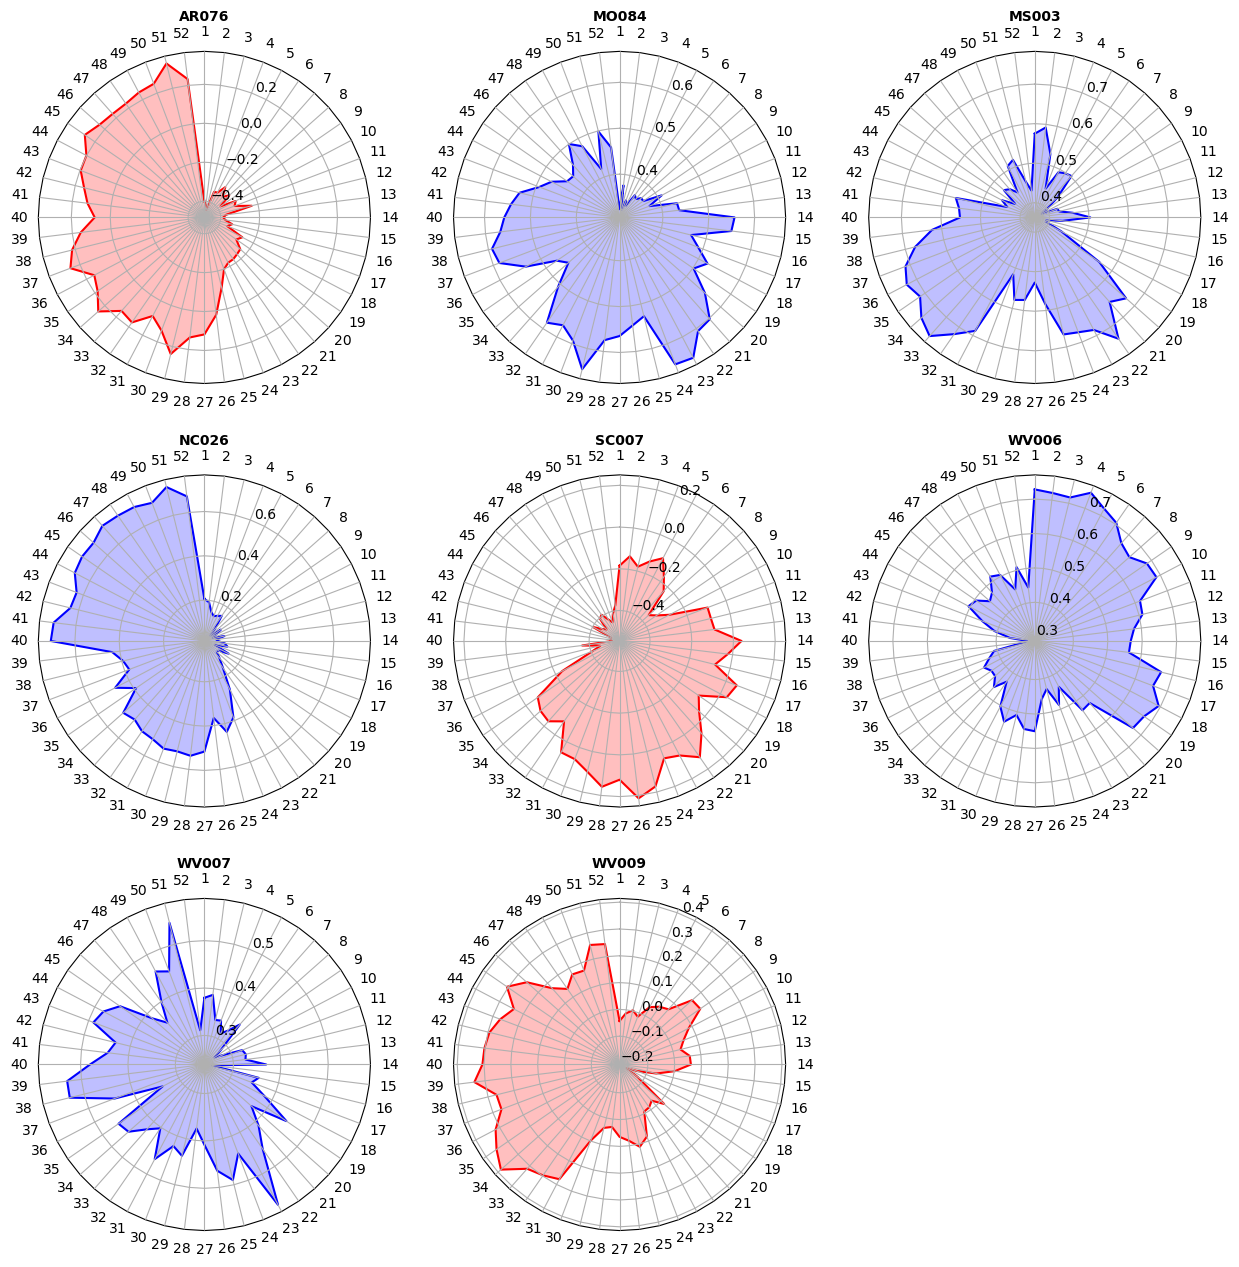

In [55]:
N = 52
theta = radar_factory(N, frame='polygon')

#east = east.drop(["AR078"])
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

#colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, idx in zip(axs.flat, np.arange(0,east.shape[0])):
    ax.set_title(east.index.values[idx], weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    case_data = east.iloc[idx,:]
    if np.min(case_data) < 0:
        val_range = np.max(case_data) - np.min(case_data)
        if val_range//0.2 <=2:
            ax.set_rgrids(np.arange(-1,1,0.1))
        else:
            ax.set_rgrids(np.arange(-1,1,0.2))
        ax.plot(theta, case_data, color="red")
        ax.set_theta_direction(-1) # reverse the direction of the angle for the polar plot
        ax.fill(theta, case_data, facecolor="red", alpha=0.25, label='_nolegend_')
    else:
        val_range = np.max(case_data) - np.min(case_data)
        if val_range//0.2 <=2:
            ax.set_rgrids(np.arange(0,1,0.1))
        else:
            ax.set_rgrids(np.arange(0,1,0.2))
        ax.plot(theta, case_data, color="blue")
        ax.set_theta_direction(-1)
        ax.fill(theta, case_data, facecolor="blue", alpha=0.25, label='_nolegend_')
    
    ax.set_varlabels(east.columns.values)
    ax.set_axisbelow(False)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                             labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, 'Weekly Correlation between ForDRI and TRSGI',
#            horizontalalignment='center', color='black', weight='bold',
#            size='large')

fig.delaxes(axs[2][2])

plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/radar_plot_easternUS.png",dpi=300)

#plt.show()

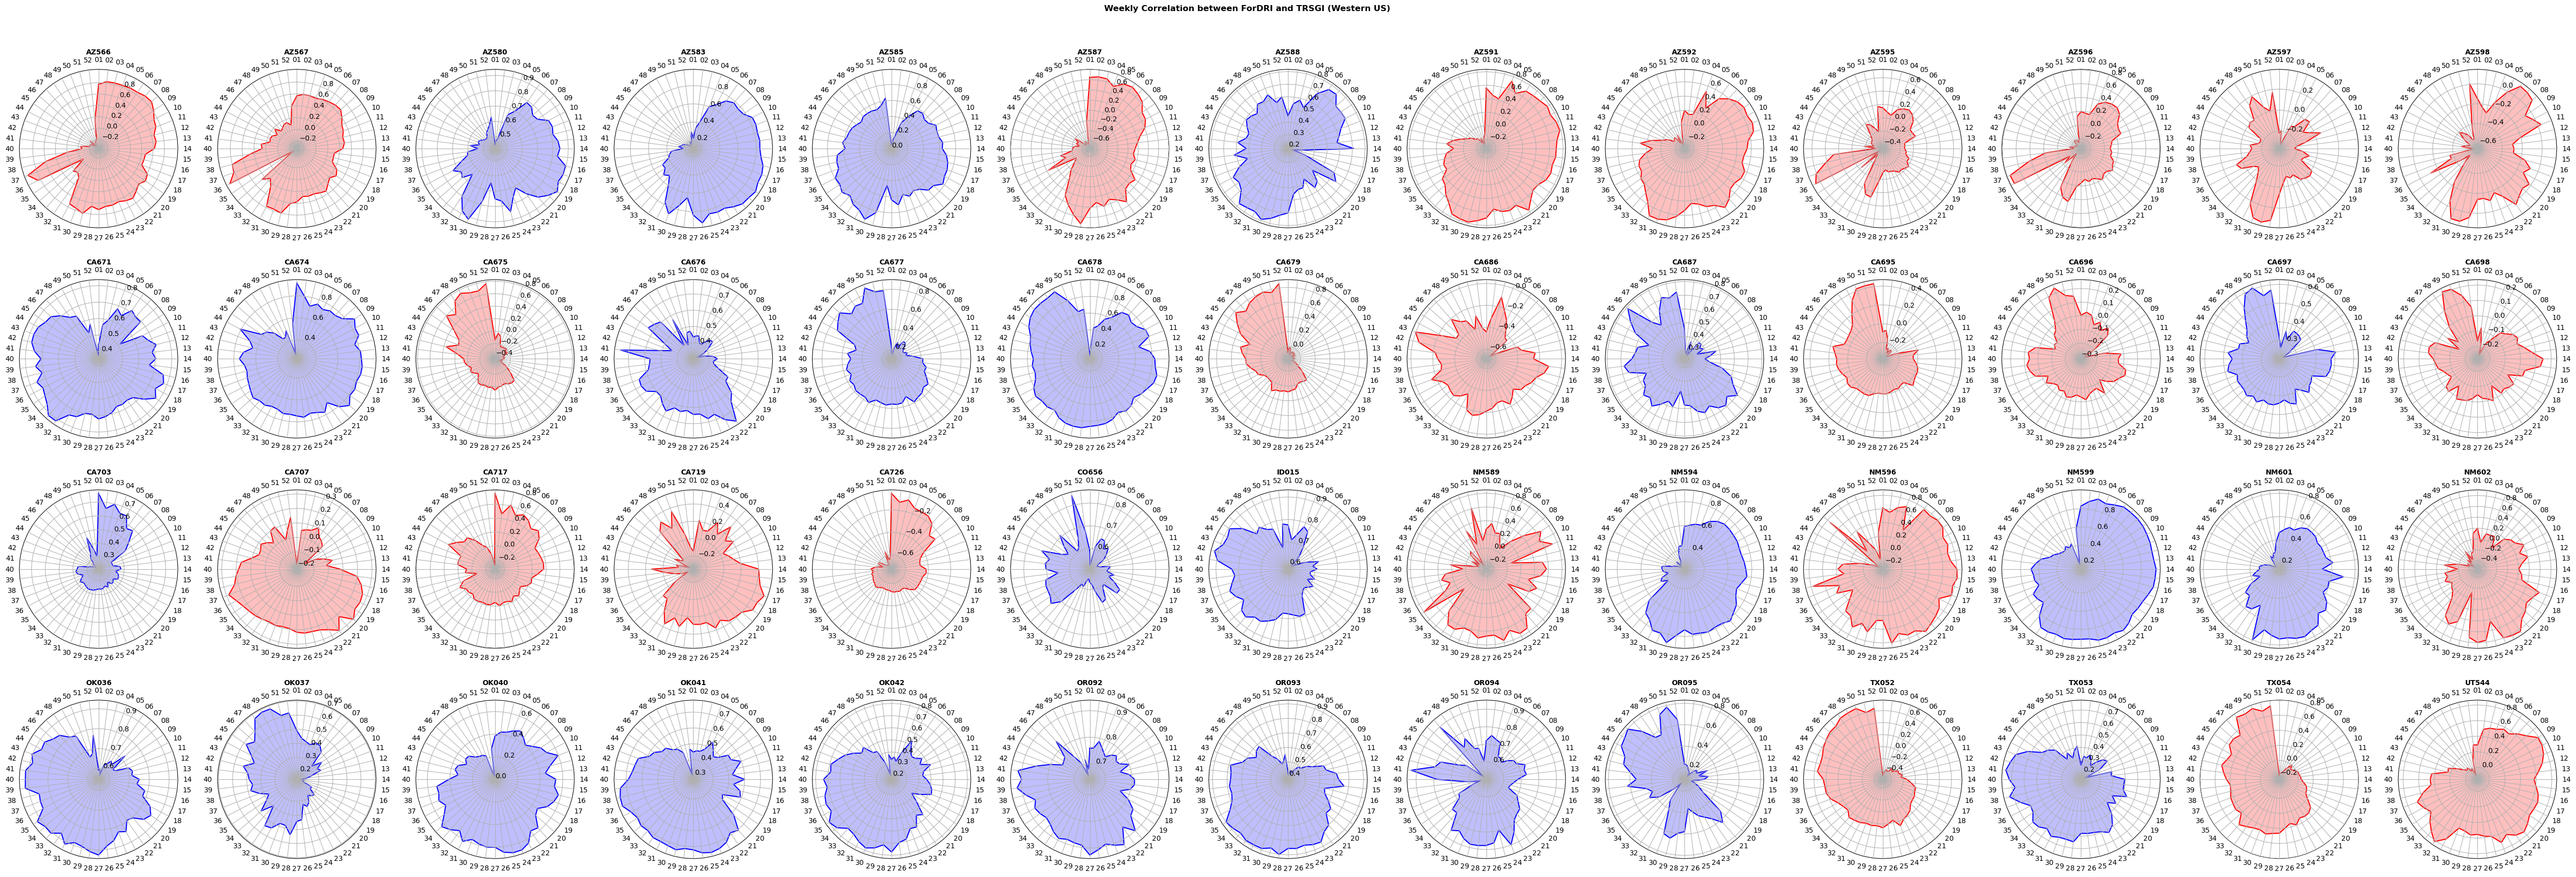

In [56]:
west.columns = wk_list
N = 52
theta = radar_factory(N, frame='polygon')


fig, axs = plt.subplots(figsize=(65,20), nrows= 4, ncols= 13,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

#colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, idx in zip(axs.flat, np.arange(0,west.shape[0])):
    ax.set_title(west.index.values[idx], weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    case_data = west.iloc[idx,:]
    if np.min(case_data) < 0:
        val_range = np.max(case_data) - np.min(case_data)
        if val_range//0.2 <=2:
            ax.set_rgrids(np.arange(-1,1,0.1))
        else:
            ax.set_rgrids(np.arange(-1,1,0.2))
        ax.plot(theta, case_data, color="red")
        ax.set_theta_direction(-1)
        ax.fill(theta, case_data, facecolor="red", alpha=0.25, label='_nolegend_')
    else:
        val_range = np.max(case_data) - np.min(case_data)
        if val_range//0.2 <=2:
            ax.set_rgrids(np.arange(0,1,0.1))
        else:
            ax.set_rgrids(np.arange(0,1,0.2))
        ax.plot(theta, case_data, color="blue")
        ax.set_theta_direction(-1)
        ax.fill(theta, case_data, facecolor="blue", alpha=0.25, label='_nolegend_')
    ax.set_varlabels(west.columns.values)
    ax.set_axisbelow(False)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                             labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.9, 'Weekly Correlation between ForDRI and TRSGI (Western US)',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/radar_plot_westernUS.png",dpi=300)

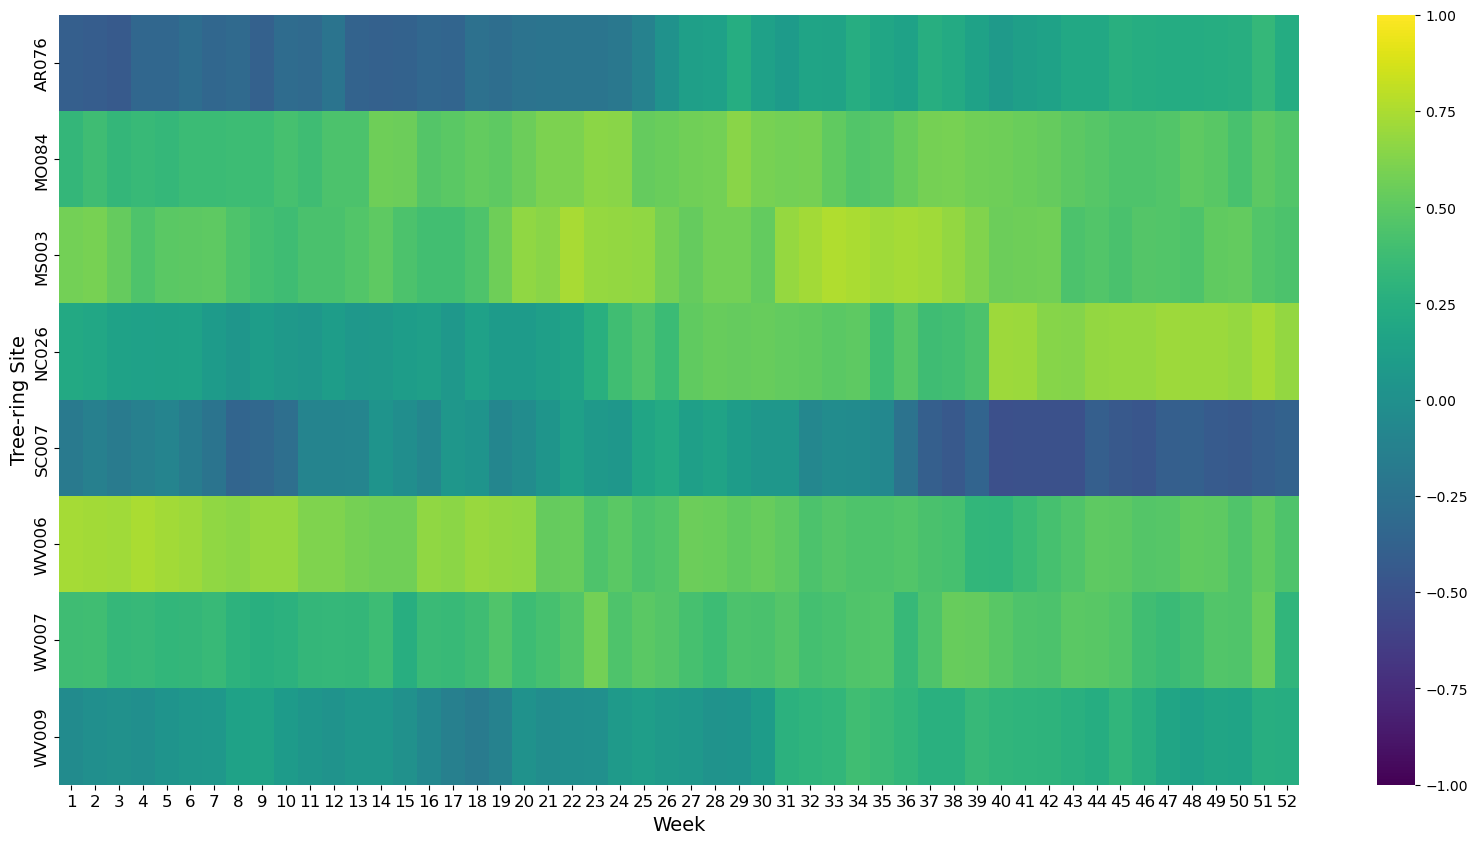

In [58]:
#heatmap
plt.figure(figsize=(20,10))
sns.heatmap(east,cmap="viridis",vmin = -1, vmax=1)
plt.xlabel("Week",fontsize=14)
plt.ylabel("Tree-ring Site",fontsize=14)
plt.yticks(va = "center",fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/east_fordri_trsgi_weeklycorr_heatmap.png",dpi=300)

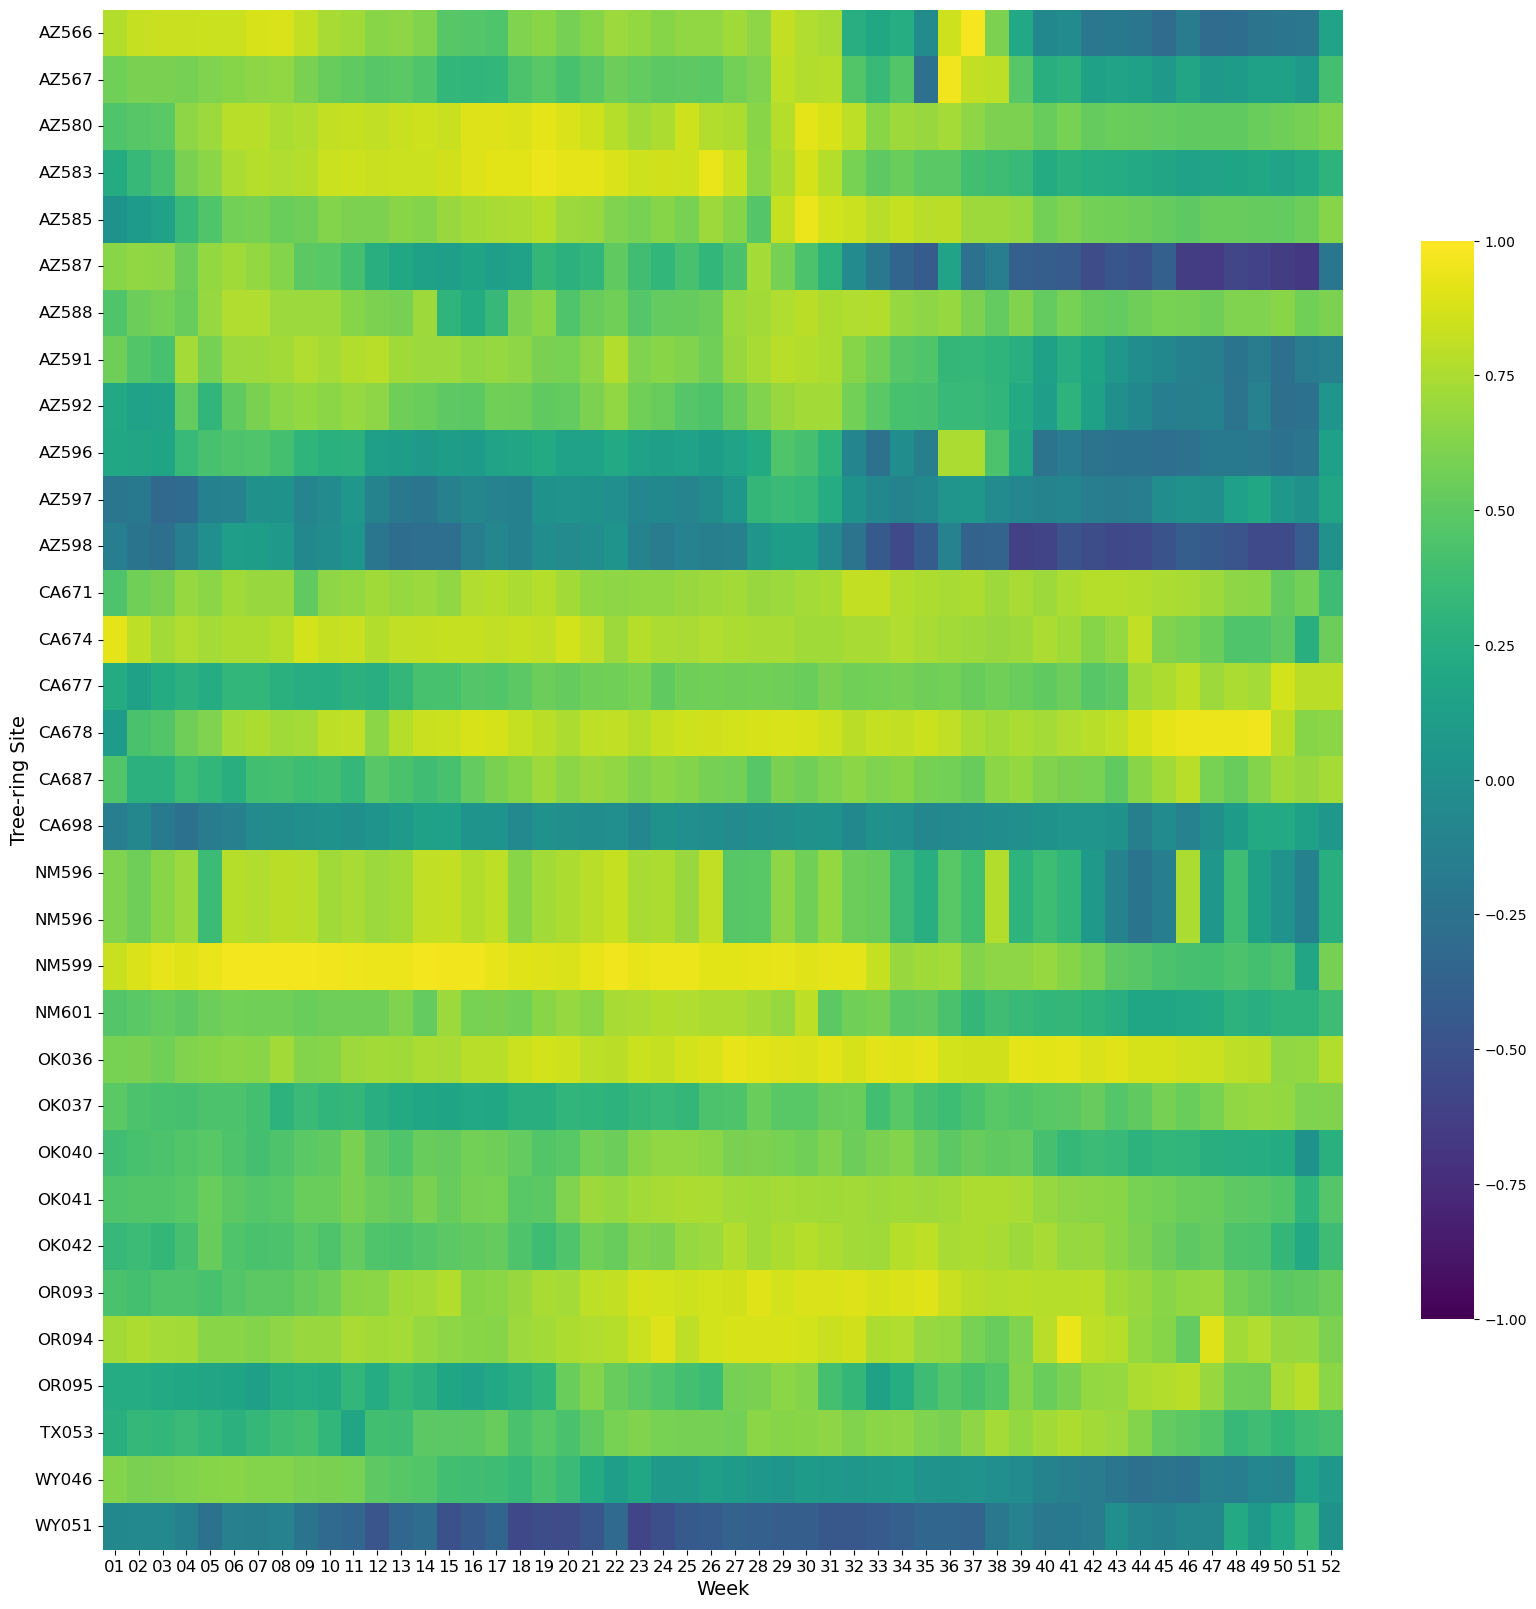

In [59]:
#heatmap
plt.figure(figsize=(20,20))
sns.heatmap(west.loc[["OK041","AZ583","CA678","AZ580","OK042","NM599","NM596","AZ587","CA698","AZ585","AZ588","NM596","AZ591","OK040",
                      "CA674","CA677","CA687","AZ598","AZ566","OK036","AZ567","AZ596","CA671","OK037","OR094","AZ592","WY046","NM601",
                      "WY051","AZ597","OR093","TX053","OR095"],:].sort_index(),cmap="viridis",vmin = -1, vmax=1,cbar_kws={"shrink": 0.7})
plt.xlabel("Week",fontsize=14)
plt.ylabel("Tree-ring Site",fontsize=14)
plt.yticks(va = "center",fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("/work/tadesse/beichen/ForDRI/Evaluation_Outputs/west_fordri_trsgi_weeklycorr_heatmap.png",dpi=300)

Same ForDRI TRSGI USDM plots with out the USDM

In [3]:
# annual
# read aggregated fordri
fordri_east_annual = pd.read_csv("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/integrated_annual_fordri_east.csv",index_col=0)
fordri_east_annual.columns = col_name= np.arange(2003,2021,1)
fordri_west_annual = pd.read_csv("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/integrated_annual_fordri_west.csv",index_col=0)
fordri_west_annual.columns = col_name= np.arange(2003,2021,1)

In [4]:
# Calculate the Spearman Correlation and plot the map (westernUS)
std_trsgi_dir = "R:/UnitedStates/ForDRI_project-NEW/tree_ring/STD_TRSGI_westernUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(np.empty((0, 2)))
out_corr_df.columns = ["ForDRI: Spearman-r", "ForDRI: Spearman-r p-value"]
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr,index_col=1).iloc[:,1:] # revised based on the western US file format
    end_year = df.index.values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    # usdm = west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    fordri = fordri_west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    #pearson_r = pearsonr(-trsgi,usdm)
    spearman_r_fordri = spearmanr(-trsgi,fordri)
    # spearman_r_usdm = spearmanr(-trsgi,usdm)
    out_corr_df.loc[stdtr_name] = [spearman_r_fordri[0],spearman_r_fordri[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "red", marker = 'v',label = "Integrated Annual ForDRI")
    ax1.set_xticks(np.arange(2003, end_year+1))
    ax1.set_xticklabels(np.arange(2003, end_year+1))
    ax1.set_ylim(-0.5, 5.5)
    ax1.set_yticks(np.arange(0,6,1))
    ax1.set_yticklabels(np.arange(0,6,1))
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    ax2.set_ylim(-5, 5)
    ax2.set_yticks(np.arange(-4,4.5,1))
    ax2.set_yticklabels(np.arange(-4,4.5,1))
    fig.legend(ncol=2, loc='lower center',bbox_to_anchor=(0.5,0))
    ax1.set_title(stdtr_name + " (Spearman r: %s)" %(str(round(spearman_r_fordri[0], 2))))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    # plt.show()
    plt.savefig("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/ForDRI_TRSGI_allseasons_westernUS/"+stdtr_name+'.png', dpi = 300)
    plt.close(fig)
    # export the csv file of the correlation
    # 
    # out_corr_df.to_csv("R:/UnitedStates/ForDRI_project-NEW/USDM_Evaluation_2023/westUS_correlation_ForDRI_USDM_TRSGI.csv")


c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [5]:
# Calculate the Spearman Correlation and plot the map (easternUS)
std_trsgi_dir = "R:/UnitedStates/ForDRI_project-NEW/tree_ring/STD_TRSGI_easternUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
#out_corr_df = pd.DataFrame(np.empty((0, 4)))
#out_corr_df.columns =  ["ForDRI: Spearman-r", "ForDRI: Spearman-r p-value"]
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    end_year = df.iloc[:,0].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = fordri_east_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    #pearson_r = pearsonr(-trsgi,usdm)
    spearman_r_fordri = spearmanr(-trsgi,fordri)
    out_corr_df.loc[stdtr_name] = [spearman_r_fordri[0],spearman_r_fordri[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "red", marker = 'v',label = "Integrated Annual ForDRI")
    ax1.set_xticks(np.arange(2003, end_year+1))
    ax1.set_xticklabels(np.arange(2003, end_year+1))
    ax1.set_ylim(-0.5, 5.5)
    ax1.set_yticks(np.arange(0,6,1))
    ax1.set_yticklabels(np.arange(0,6,1))
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    ax2.set_ylim(-5, 5)
    ax2.set_yticks(np.arange(-4,4.5,1))
    ax2.set_yticklabels(np.arange(-4,4.5,1))
    fig.legend(ncol=2, loc='lower center',bbox_to_anchor=(0.5,0))
    ax1.set_title(stdtr_name + " (Spearman r: %s)" %(str(round(spearman_r_fordri[0], 2))))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    # plt.show()
    plt.savefig("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/ForDRI_TRSGI_allseasons_easternUS/"+stdtr_name+'.png', dpi = 300)
    plt.close(fig)

In [6]:
# growing seasong
# read aggregated fordri
fordri_east_annual = pd.read_csv("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/integrated_growing_Season_fordri_east.csv",index_col=0)
fordri_east_annual.columns = col_name= np.arange(2003,2021,1)
fordri_west_annual = pd.read_csv("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/integrated_growing_Season_fordri_west.csv",index_col=0)
fordri_west_annual.columns = col_name= np.arange(2003,2021,1)

In [7]:
# Calculate the Spearman Correlation and plot the map (westernUS)
std_trsgi_dir = "R:/UnitedStates/ForDRI_project-NEW/tree_ring/STD_TRSGI_westernUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
out_corr_df = pd.DataFrame(np.empty((0, 2)))
out_corr_df.columns = ["ForDRI: Spearman-r", "ForDRI: Spearman-r p-value"]
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr,index_col=1).iloc[:,1:] # revised based on the western US file format
    end_year = df.index.values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    # usdm = west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    fordri = fordri_west_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    #pearson_r = pearsonr(-trsgi,usdm)
    spearman_r_fordri = spearmanr(-trsgi,fordri)
    # spearman_r_usdm = spearmanr(-trsgi,usdm)
    out_corr_df.loc[stdtr_name] = [spearman_r_fordri[0],spearman_r_fordri[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "red", marker = 'v',label = "Integrated Annual ForDRI")
    ax1.set_xticks(np.arange(2003, end_year+1))
    ax1.set_xticklabels(np.arange(2003, end_year+1))
    ax1.set_ylim(-0.5, 5.5)
    ax1.set_yticks(np.arange(0,6,1))
    ax1.set_yticklabels(np.arange(0,6,1))
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    ax2.set_ylim(-5, 5)
    ax2.set_yticks(np.arange(-4,4.5,1))
    ax2.set_yticklabels(np.arange(-4,4.5,1))
    fig.legend(ncol=2, loc='lower center',bbox_to_anchor=(0.5,0))
    ax1.set_title(stdtr_name + " (Spearman r: %s)" %(str(round(spearman_r_fordri[0], 2))))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    # plt.show()
    plt.savefig("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/ForDRI_TRSGI_growingseasons_westernUS/"+stdtr_name+'.png', dpi = 300)
    plt.close(fig)
    # export the csv file of the correlation
    # 
    # out_corr_df.to_csv("R:/UnitedStates/ForDRI_project-NEW/USDM_Evaluation_2023/westUS_correlation_ForDRI_USDM_TRSGI.csv")


c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

c:\Users\bzhang25\Anaconda3\envs\mywork\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [8]:
# Calculate the Spearman Correlation and plot the map (easternUS)
std_trsgi_dir = "R:/UnitedStates/ForDRI_project-NEW/tree_ring/STD_TRSGI_easternUS/"
std_trsgi_list = glob.glob(std_trsgi_dir+"*.csv")
std_trsgi_list.sort()
#out_corr_df = pd.DataFrame(np.empty((0, 4)))
#out_corr_df.columns =  ["ForDRI: Spearman-r", "ForDRI: Spearman-r p-value"]
for stdtr in std_trsgi_list:
    stdtr_name = os.path.basename(stdtr)[:5].upper()
    df = pd.read_csv(stdtr)
    end_year = df.iloc[:,0].values[-1]
    trsgi = df.iloc[-(end_year-2003+1):,-1].values
    fordri = fordri_east_annual.loc[stdtr_name,np.arange(2003,end_year+1,1).tolist()].values
    #pearson_r = pearsonr(-trsgi,usdm)
    spearman_r_fordri = spearmanr(-trsgi,fordri)
    out_corr_df.loc[stdtr_name] = [spearman_r_fordri[0],spearman_r_fordri[1]]
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(2003, end_year+1), fordri, color = "red", marker = 'v',label = "Integrated Annual ForDRI")
    ax1.set_xticks(np.arange(2003, end_year+1))
    ax1.set_xticklabels(np.arange(2003, end_year+1))
    ax1.set_ylim(-0.5, 5.5)
    ax1.set_yticks(np.arange(0,6,1))
    ax1.set_yticklabels(np.arange(0,6,1))
    ax1.set_ylabel("Integrated Annual ForDRI")
    # ax1.set_ylim(0.5,4)
    ax1.xaxis.grid()
    ax2 = ax1.twinx()
    ax2.plot(np.arange(2003, end_year+1), -trsgi, color = "green", marker = 'o', label = "Negative STD TRSGI")
    ax2.set_ylabel("Negative STD TRSGI")
    ax2.set_ylim(-5, 5)
    ax2.set_yticks(np.arange(-4,4.5,1))
    ax2.set_yticklabels(np.arange(-4,4.5,1))
    fig.legend(ncol=2, loc='lower center',bbox_to_anchor=(0.5,0))
    ax1.set_title(stdtr_name + " (Spearman r: %s)" %(str(round(spearman_r_fordri[0], 2))))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    # plt.show()
    plt.savefig("R:/UnitedStates/ForDRI_project-NEW/NEW_Evaluation_2022/New_Results/ForDRI_TRSGI_growingseasons_easternUS/"+stdtr_name+'.png', dpi = 300)
    plt.close(fig)